In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from tqdm import tqdm
from scipy.integrate import simps
import matplotlib.pyplot as plt
import imageio
from helpers import (Fy, find_closest_element, predict_single_density, compute_coverage, 
confidence_interval, confidence_interval, generate_fixed_terms, get_ci, KL)
import _pickle as cPickle

In [2]:
# read in val data
B_zeta = np.load('../../../data/commaai/extracted_coefficients/20201027_filtered_gaussian_resampled/Bzeta/B_zeta_val.npy')
true_y = np.load('../../../data/commaai/extracted_coefficients/20201027_filtered_gaussian_resampled/Bzeta/labels_val.npy')

density_path = '../../../data/commaai/density/gaussian_density_filtered.csv'
density = pd.read_csv(density_path)

In [3]:
no_points = 500
p_y_y0, part_1, phi_1_z, grid = generate_fixed_terms(no_points, density)

## 1. VA + RIDGE + PRECISE

In [4]:
va_ridge_dir = '../../../data/commaai/va/filtered_gaussian_resampled/Ridge/'
mu_t_va = np.genfromtxt(va_ridge_dir + 'vartheta_factor_4_50.csv', delimiter = ',')
iterations = mu_t_va.shape[0]
beta = np.mean(mu_t_va[int(0.9*iterations):iterations,0:10], axis = 0)
tau_sq = np.mean(np.exp(mu_t_va[int(0.9*iterations):iterations,10]), axis = 0)
p = len(beta)
z_pred = B_zeta.reshape(B_zeta.shape[0], p).dot(beta)
pred_y = [density.loc[find_closest_element(norm.cdf(z), density['cdf']), 'axes'] for z in z_pred]

In [5]:
densities_va_ridge = []
for i in tqdm(range(0, B_zeta.shape[0])):
    dens = predict_single_density(B_zeta[i].reshape(p,), grid, p_y_y0, part_1, phi_1_z, beta, tau_sq, None, 'va_ridge')
    densities_va_ridge.append(dens)

100%|██████████| 10472/10472 [00:21<00:00, 483.44it/s]


In [6]:
confidence_intervals, conf_width = get_ci(B_zeta, grid, pred_y, density,  p_y_y0, part_1, phi_1_z, beta, tau_sq, p, None, 'va_ridge')

100%|██████████| 10472/10472 [26:58<00:00,  6.47it/s]


In [10]:
print('Mean 95% confidence interval width ' + str(np.mean(conf_width)) + ' degree.')

Mean 95% confidence interval width 10.971476432861754 degree.


In [44]:
np.std(conf_width)

1.3811367130321246

Text(0, 0.5, '95% confidence interval width')

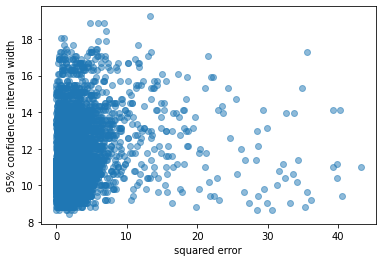

In [11]:
abs_error = np.abs(pred_y[:len(conf_width)] - true_y[:len(conf_width)])
plt.scatter( abs_error, conf_width, alpha = 0.5)
plt.xlabel('squared error')
plt.ylabel('95% confidence interval width')

In [12]:
np.corrcoef(np.abs(pred_y[:len(conf_width)] - true_y[:len(conf_width)]), np.array(conf_width))

array([[1.        , 0.22254494],
       [0.22254494, 1.        ]])

In [13]:
print('coverage rate: ' + str(compute_coverage(confidence_intervals, true_y)))

coverage rate: 0.9567417876241405


In [15]:
df = pd.DataFrame({'conf_width_va_ridge_precise': conf_width})
#df.to_csv('conf_width_va_ridge_precise.csv')

## 2. VA + Horseshoe + PRECISE

In [ ]:
va_horse_dir = '../../../data/commaai/va/filtered_gaussian_resampled/Horseshoe/'
mu_t_va = np.load(va_horse_dir + 'mu_ts.npy').reshape(29001, 21)
beta = np.mean(mu_t_va[20000:,0:10], axis = 0)
Lambda = np.mean(np.exp(0.5*mu_t_va[20000:,10:20]), axis = 0)
tau_sq = np.exp(np.mean(mu_t_va[20000:,20], axis = 0))
z_pred = B_zeta.reshape(B_zeta.shape[0], p).dot(beta)
pred_y = [density.loc[find_closest_element(norm.cdf(z), density['cdf']), 'axes'] for z in z_pred]

In [ ]:
def predict_single_density(psi_x0, grid, p_y_y0, part_1, phi_1_z, beta, tau_sq, Lambda, method):
    
    f_eta_x0 = psi_x0.dot(beta)

    if method == 'va_ridge':
        s_0_hat = (1 + tau_sq*psi_x0.dot(psi_x0))**(-0.5)
        
    if method == 'hmc_ridge':
        s_0_hat_js = []
        for tau_j in tau_sq:
            s_0_hat_j = (1 + tau_j*psi_x0.dot(psi_x0))**(-0.5)
            s_0_hat_js.append(s_0_hat_j)
        s_0_hat = np.mean(np.array(s_0_hat_js))

    elif method == 'va_horseshoe': 
        s_0_hat = (1 + (psi_x0*(Lambda**2)).dot(psi_x0))**(-0.5)
    
    elif method == 'hmc_horseshoe':
        s_0_hat_js = []
        for lambda_j in Lambda:
            s_0_hat_j = (1 + (psi_x0*lambda_j**2).dot(psi_x0))**(-0.5)
            s_0_hat_js.append(s_0_hat_j)
        s_0_hat = np.mean(np.array(s_0_hat_js))

    part_0 = s_0_hat*f_eta_x0

    # compute the cdf of new ys
    term_1 = norm(0, 1).pdf((part_1- part_0) / s_0_hat)
    p_y_single_obs_whole_dens = (p_y_y0/phi_1_z)*(1/s_0_hat)*term_1

    return(p_y_single_obs_whole_dens)

In [ ]:

def get_ci(B_zeta, grid, pred_y, density,  p_y_y0, part_1, phi_1_z, beta, tau_sq, p,  Lambda, method):
    densities_va = []
    for i in tqdm(range(0, B_zeta.shape[0])):
        dens = predict_single_density(B_zeta[i].reshape(p,), grid, p_y_y0, part_1, phi_1_z, beta, tau_sq, Lambda, method)
        densities_va.append(dens)
    confidence_intervals = []
    
    for i in tqdm(range(0, len(pred_y))):
        confidence_intervals.append(confidence_interval(densities_va[i], pred_y[i], density, 0.95, grid))
    conf_width = [element[1] - element[0] for element in confidence_intervals]
    return(confidence_intervals, conf_width)

In [ ]:
densities_va_horse = []
for i in tqdm(range(0, B_zeta.shape[0])):
    dens = predict_single_density(B_zeta[i].reshape(p,), grid, p_y_y0, part_1, phi_1_z, beta, tau_sq, Lambda,  'va_horseshoe')
    densities_va_horse.append(dens)

In [ ]:
confidence_intervals_horse, conf_width_horse = get_ci(B_zeta, grid, pred_y, density,  p_y_y0, part_1, phi_1_z, beta, tau_sq, p, Lambda, 'va_horseshoe')

In [ ]:
print('coverage rate: ' + str(compute_coverage(confidence_intervals_horse, true_y)))

In [ ]:
df['va_horseshoe_precise'] = conf_width_horse
df.to_csv('conf_width_va_ridge_precise.csv')

In [ ]:
np.corrcoef(np.abs(pred_y[:len(conf_width_horse)] - true_y[:len(conf_width_horse)]), np.array(conf_width_horse))

In [ ]:
abs_error = np.abs(pred_y[:len(conf_width)] - true_y[:len(conf_width)])

In [ ]:
plt.scatter( abs_error, conf_width, alpha = 0.5)
plt.xlabel('squared error')
plt.ylabel('95% confidence interval width')
# when confidence interval small, almost no risk of wrong decision

In [ ]:
print('Mean 95% confidence interval width ' + str(np.mean(conf_width_horse)) + ' degree.')

In [ ]:
np.std(conf_width_horse)

# HMC + Horseshoe + Precise

In [ ]:
with open(r"../../../data/commaai/mcmc/filtered_gaussian_resampled/Horseshoe/horseshoe_hmc.p", "rb") as input_file:
    hmc_horseshoe = cPickle.load(input_file)

In [ ]:
betas_hmc_horse = np.mean(hmc_horseshoe['beta'], axis = 0)
lambdas_hmc_horse = hmc_horseshoe['lambda']
#taus_hmc_horse = hmc_horseshoe['tau']
#betas_hmc_horse = np.std(hmc_horseshoe['beta'], axis = 0)
#lambdas_hmc_horse = np.std(hmc_horseshoe['lambda'], axis = 0)
#taus_hmc_horse = np.std(hmc_horseshoe['tau'], axis = 0)

In [ ]:
densities_hmc_horse = []
for i in tqdm(range(0, B_zeta.shape[0])):
    dens = predict_single_density(B_zeta[i].reshape(p,), grid, p_y_y0, part_1, phi_1_z, beta, tau_sq, Lambda, 'hmc_horseshoe')
    densities_hmc_horse.append(dens)

In [ ]:
confidence_intervals_horse, conf_width_horse = get_ci(B_zeta, grid, pred_y, density,  p_y_y0, part_1, phi_1_z, beta, tau_sq, p, Lambda, 'va_horseshoe')

In [ ]:
print('Mean 95% confidence interval width ' + str(np.mean(conf_width_horse)) + ' degree.')

In [ ]:
np.std(conf_width_horse)

In [ ]:
abs_error = np.abs(pred_y[:len(conf_width_horse)] - true_y[:len(conf_width_horse)])
plt.scatter( abs_error, conf_width_horse, alpha = 0.5)
plt.xlabel('squared error')
plt.ylabel('95% confidence interval width')

In [ ]:
np.corrcoef(np.abs(pred_y[:len(conf_width_horse)] - true_y[:len(conf_width_horse)]), np.array(conf_width_horse))

In [ ]:
print('coverage rate: ' + str(compute_coverage(confidence_intervals_horse, true_y)))

# HMC + Ridge + Precise

In [23]:
hmc_ridge_dir = '../../../data/commaai/mcmc/filtered_gaussian_resampled/Ridge/'
mu_t_hmc = np.load(hmc_ridge_dir + 'all_thetas_L100.npy')[100:,:]
beta = np.mean(mu_t_hmc[:,0:10], axis = 0)
tau_sq = np.exp(mu_t_hmc[:,10])
z_pred = B_zeta.reshape(B_zeta.shape[0], p).dot(beta)
pred_y = [density.loc[find_closest_element(norm.cdf(z), density['cdf']), 'axes'] for z in z_pred]

In [24]:
densities_hmc_ridge = []
for i in tqdm(range(0, B_zeta.shape[0])):
    dens = predict_single_density(B_zeta[i].reshape(p,), grid, p_y_y0, part_1, phi_1_z, beta, tau_sq, None, 'hmc_ridge')
    densities_hmc_ridge.append(dens)

100%|██████████| 10472/10472 [01:28<00:00, 118.13it/s]


In [36]:
confidence_intervals_ridge_hmc, conf_width_ridge_hmc = get_ci(B_zeta, grid, pred_y, density,  p_y_y0, part_1, phi_1_z, beta, tau_sq, p, None, 'hmc_ridge')

100%|██████████| 10472/10472 [30:23<00:00,  5.74it/s]


In [ ]:
df['hmc_ridge_precise'] = conf_width_ridge_hmc
df.to_csv('conf_width_va_ridge_precise.csv')

Text(0, 0.5, '95% confidence interval width')

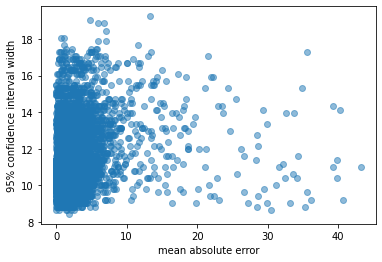

In [37]:
abs_error = np.abs((pred_y[:len(conf_width)] - true_y[:len(conf_width_ridge_hmc)]))
plt.scatter( abs_error, conf_width_ridge_hmc, alpha = 0.5)
plt.xlabel('mean absolute error')
plt.ylabel('95% confidence interval width')
# when confidence interval small, almost no risk of wrong decision

In [38]:
print('Mean 95% confidence interval width ' + str(np.mean(conf_width_ridge_hmc)) + ' degree.')

Mean 95% confidence interval width 10.978974708171254 degree.


In [39]:
np.std(conf_width_ridge_hmc)

1.3878462730028351

In [40]:
print('coverage rate: ' + str(compute_coverage(confidence_intervals_ridge_hmc, true_y)))

coverage rate: 0.9569327731092437


In [41]:
np.corrcoef(np.abs(pred_y[:len(conf_width_ridge_hmc)] - true_y[:len(conf_width_ridge_hmc)]), np.array(conf_width_ridge_hmc))

array([[1.        , 0.22418158],
       [0.22418158, 1.        ]])

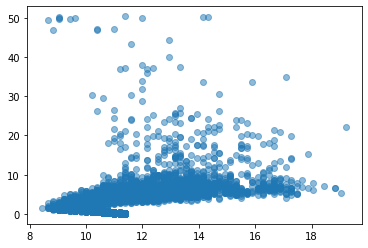

In [42]:
plt.scatter(conf_width_ridge_hmc, np.abs(pred_y), alpha = 0.5)
# confidence intervals are larger for larger predictions!

In [45]:
df['conf_width_hmc_ridge_precise'] =  conf_width_ridge_hmc

In [43]:
np.corrcoef(np.abs(pred_y[:len(conf_width_ridge_hmc)]), np.abs(pred_y))

array([[1., 1.],
       [1., 1.]])

In [51]:
kl_div = [KL(densities_hmc_ridge[i], densities_va_ridge[i]) for i in range(0, len(densities_hmc_ridge))]

In [52]:
np.std(kl_div)

1.1448167430575266e-05

In [ ]:
hmc_ridge_dir = '../../../data/commaai/mcmc/filtered_gaussian_resampled/Ridge/'
mu_t_va = np.load(va_horse_dir + 'all_thetas.npy').reshape(29001, 21)
beta = np.mean(mu_t_va[20000:,0:10], axis = 0)
Lambda = np.mean(np.exp(0.5*mu_t_va[20000:,10:20]), axis = 0)
tau_sq = np.exp(np.mean(mu_t_va[20000:,20], axis = 0))
z_pred = B_zeta.reshape(B_zeta.shape[0], p).dot(beta)
pred_y = [density.loc[find_closest_element(norm.cdf(z), density['cdf']), 'axes'] for z in z_pred]

In [ ]:
compute_coverage(confidence_intervals_horse, true_y)

In [ ]:
# HMC +  Ridge + Imprecise

# 3. DNNC

In [ ]:
beta_dnnc = np.genfromtxt('../../../data/commaai/extracted_coefficients/20201027_filtered_gaussian_resampled/beta/beta.csv', delimiter = ",")
beta_dnnc0 = np.genfromtxt('../../../data/commaai/extracted_coefficients/20201027_filtered_gaussian_resampled/beta/beta0.csv', delimiter = ",")
beta_dnnc = np.append(beta_dnnc, beta_dnnc0)

In [ ]:
def predict_single_density(x, grid, p_y_y0, part_1, phi_1_z, beta, tau_sq, Lambda, method):
    
    psi_x0 = x
    if method == 'dnn_c':
        f_eta_x0 = psi_x0.dot(beta[0:p]) + beta[p]
    else:
        f_eta_x0 = psi_x0.dot(beta)

    if method == 'va_ridge':
        s_0_hat = (1 + tau_sq*psi_x0.dot(psi_x0))**(-0.5)
    
    elif method == 'hmc_ridge':
        s_0_hats =  []
        for tau_j in tau_sq:
            s_0_hatj = (1 + tau_j*psi_x0.dot(psi_x0))**(-0.5)
            s_0_hats.append(s_0_hatj)
        s_0_hat = np.mean(np.array(s_0_hats))

    elif method == 'va_horseshoe' or method == 'hmc_horseshoe':
        s_0_hat = (1 + (psi_x0*(Lambda**2)).dot(psi_x0))**(-0.5)
    
    if method == 'dnn_c':
        s_0_hat = (1 + psi_x0.dot(psi_x0))**(-0.5)

    part_0 = s_0_hat*f_eta_x0

    # compute the cdf of new ys
    term_1 = norm(0, 1).pdf((part_1- part_0) / s_0_hat)
    p_y_single_obs_whole_dens = (p_y_y0/phi_1_z)*(1/s_0_hat)*term_1

    return(p_y_single_obs_whole_dens)

In [ ]:
def get_ci(B_zeta, grid, pred_y, density,  p_y_y0, part_1, phi_1_z, beta, tau_sq, p,  Lambda, method):
    densities_va = []
    for i in tqdm(range(0, B_zeta.shape[0])):
        dens = predict_single_density(B_zeta[i].reshape(p,), grid, p_y_y0, part_1, phi_1_z, beta, tau_sq, Lambda, method)
        densities_va.append(dens)
    confidence_intervals = []
    
    for i in tqdm(range(0, len(pred_y))):
        confidence_intervals.append(confidence_interval(densities_va[i], pred_y[i], density, 0.95, grid))
    conf_width = [element[1] - element[0] for element in confidence_intervals]
    return(confidence_intervals, conf_width)

In [ ]:
confidence_intervals_dnnc, conf_width_dnnc = get_ci(B_zeta, grid, pred_y, density,  p_y_y0, part_1, phi_1_z, beta_dnnc, None, p, None, 'dnn_c')

In [ ]:
abs_error = np.abs((pred_y[:len(conf_width)] - true_y[:len(conf_width_ridge_hmc)]))
plt.scatter( abs_error, conf_width_ridge_hmc, alpha = 0.5)
plt.xlabel('mean absolute error')
plt.ylabel('95% confidence interval width')

In [ ]:
print('Mean 95% confidence interval width ' + str(np.mean(conf_width_dnnc)) + ' degree.')

In [ ]:
np.std(conf_width_dnnc)

In [ ]:
print('coverage rate: ' + str(compute_coverage(confidence_intervals_dnnc, true_y)))

In [ ]:
np.corrcoef(np.abs(pred_y[:len(conf_width_dnnc)] - true_y[:len(conf_width_dnnc)]), np.array(conf_width_dnnc))

In [ ]:
np.corrcoef(np.abs(pred_y[:len(conf_width_dnnc)]), np.abs(pred_y))

## Compare all densities

In [ ]:
densities_va_ridge, densities_hmc_horse, densities_hmc_ridge, densities_va_horse

In [ ]:

def KL(P,Q):
    epsilon = 0.00001
    P = P.copy() +epsilon
    Q = Q.copy() +epsilon

    divergence = np.sum(P*np.log(P/Q))
    return divergence

In [ ]:
np.mean(np.array([KL(densities_va_ridge[i], densities_va_horse[i]) for i in range(0, len(densities_va_horse))]))

In [ ]:
np.std(np.array([KL(densities_va_ridge[i], densities_va_horse[i]) for i in range(0, len(densities_va_horse))]))

In [ ]:
np.mean(np.array([KL(densities_va_ridge[i], densities_hmc_ridge[i]) for i in range(0, len(densities_va_horse))]))

In [ ]:
np.std(np.array([KL(densities_va_ridge[i], densities_hmc_ridge[i]) for i in range(0, len(densities_va_horse))]))

In [ ]:
np.mean(np.array([KL(densities_va_ridge[i], densities_hmc_horse[i]) for i in range(0, len(densities_va_horse))]))

In [ ]:
np.std(np.array([KL(densities_va_ridge[i], densities_hmc_horse[i]) for i in range(0, len(densities_va_horse))]))

In [ ]:
np.mean(np.array([KL(densities_va_ridge[i], densities_hmc_ridge[i]) for i in range(0, len(densities_va_horse))]))

In [ ]:
np.std(np.array([KL(densities_va_ridge[i], densities_hmc_horse[i]) for i in range(0, len(densities_va_horse))]))

In [ ]:
np.mean(np.array([KL(densities_hmc_ridge[i], densities_va_ridge[i]) for i in range(0, len(densities_va_horse))]))

In [ ]:
np.mean(np.array([KL(densities_hmc_ridge[i], densities_hmc_horse[i]) for i in range(0, len(densities_va_horse))]))

In [ ]:
np.std(np.array([KL(densities_hmc_ridge[i], densities_hmc_horse[i]) for i in range(0, len(densities_va_horse))]))

In [ ]:
np.std(np.array([KL(densities_va_horse[i], densities_hmc_horse[i]) for i in range(0, len(densities_va_horse))]))

In [ ]:
np.mean(np.array([KL(densities_hmc_horse[i], densities_hmc_horse[i]) for i in range(0, len(densities_va_horse))]))

In [ ]:
np.std(np.array([KL(densities_hmc_horse[i], densities_hmc_horse[i]) for i in range(0, len(densities_va_horse))]))

In [ ]:
"{:.7f}". format(7.694e-06)

## Playground

In [15]:
import imageio

In [225]:
for i in range(1, 22):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    axes[0].imshow(imageio.imread(paths[i]))
    axes[0].axes.get_yaxis().set_visible(False)   
    axes[0].axes.get_xaxis().set_visible(False)   
    axes[1].plot(grid, (densities_va_ridge[i]))
    axes[1].vlines(0, 0, 0.5, color = 'black', alpha = 0.5)
    axes[1].axes.set_xlim(-20,20)
    axes[1].axes.set_ylim(0, 0.4)
    axes[1].axes.get_yaxis().set_visible(False)   
    axes[1].invert_xaxis()
    plt.tight_layout()
    name = str('../../../data/commaai/gif/gif1/angle_' + str(i) + '.png')
    plt.savefig(str(name))
    plt.close()

In [144]:
plt.savefig('angle_21.png')

<Figure size 432x288 with 0 Axes>

In [94]:
path_all_imgs = '../../../data/commaai/training_files_filtered/indices/val_indices.csv'
all_img_df = pd.read_csv(path_all_imgs)
img_path_base = '../../../data/commaai/train_bags_2/'
paths = img_path_base + all_img_df['path'][0:50]

In [218]:
img = imageio.imread('../../../data/commaai/gif/gif1/angle_20.png')

In [226]:
import glob
list_img = glob.glob("../../../data/commaai/gif/gif1/*.png")

In [228]:
import imageio
images = []
for filename in list_img:
    images.append(imageio.imread(filename))
imageio.mimsave('../../../data/commaai/gif/gif1/movie.gif', images, fps= 2)

# pro version

In [292]:
def plot_density(ang_dens, c, r, axes):
    ang_dens['angle_rad'] = ang_dens['angle'].apply(lambda x: x / 180. * np.pi + np.pi / 2)
    ang_dens['t'] = ang_dens['angle_rad'].apply(lambda x: (c[0] + np.cos(x) * r, c[1] - np.sin(x) * r))
    for i in range(0, ang_dens['t'].shape[0]):
        t = ang_dens['t'][i]
        dens = max(0,ang_dens['density'][i]*const)
        axes.plot((c[0], t[0]), (c[1], t[1]), 'dodgerblue', alpha = dens)

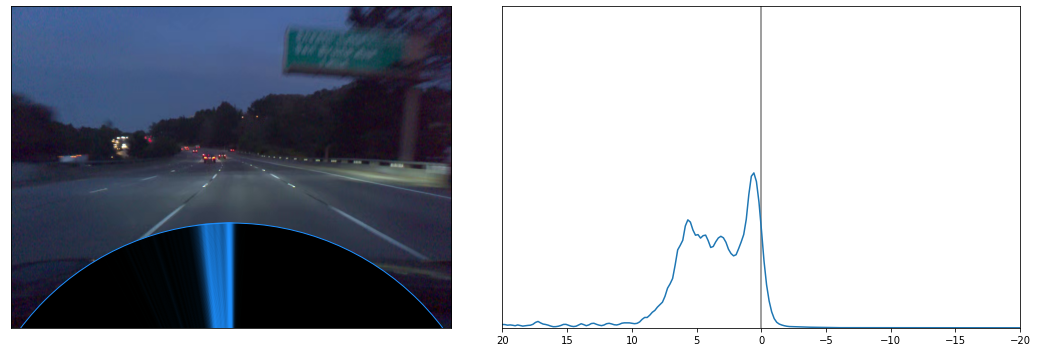

In [293]:
i = 1
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ang_dens = pd.DataFrame({'angle': grid, 'density': densities_va_ridge[i]})
max_dens = max(ang_dens['density'])
const = 1/max_dens
axes[0].imshow(imageio.imread(paths[1]))
#a_rad = label / 180. * np.pi + np.pi / 2
c, r = (584,1273), 700 #center, radius
plot_density(ang_dens, c, r, axes[0])
axes[0].add_artist(plt.Circle(c, r, edgecolor='dodgerblue', facecolor='k'))
axes[0].axes.get_yaxis().set_visible(False)   
axes[0].axes.get_xaxis().set_visible(False) 
axes[0].axes.set_ylim(850,0)
axes[1].plot(grid, (densities_va_ridge[i]))
axes[1].vlines(0, 0, 0.5, color = 'black', alpha = 0.5)
axes[1].axes.set_xlim(-20,20)
axes[1].axes.set_ylim(0, 0.4)
axes[1].axes.get_yaxis().set_visible(False)   
axes[1].invert_xaxis()
plt.tight_layout()


In [294]:
for i in range(1, 22):
    fig, axes = plt.subplots(nrows=1, ncols=1)
    ang_dens = pd.DataFrame({'angle': grid, 'density': densities_va_ridge[i]})
    max_dens = max(ang_dens['density'])
    const = 1/max_dens
    axes.imshow(imageio.imread(paths[i]))
    #a_rad = label / 180. * np.pi + np.pi / 2
    c, r = (584,1273), 700 #center, radius
    plot_density(ang_dens, c, r, axes)
    axes.axes.set_ylim(850,0)
    axes.add_artist(plt.Circle(c, r, edgecolor='dodgerblue', facecolor='k'))
    axes.axes.get_yaxis().set_visible(False)   
    axes.axes.get_xaxis().set_visible(False)   
    plt.tight_layout()
    name = str('../../../data/commaai/gif/gif1/angle_' + str(i) + '_tacho.png')
    plt.savefig(str(name))
    plt.close()

In [295]:
import glob
list_img = glob.glob("../../../data/commaai/gif/gif1/*_tacho.png")

In [296]:
import imageio
images = []
for filename in list_img:
    images.append(imageio.imread(filename))
imageio.mimsave('../../../data/commaai/gif/gif1/movie2.gif', images, fps = 10)